### Testing Matlab function from Python 

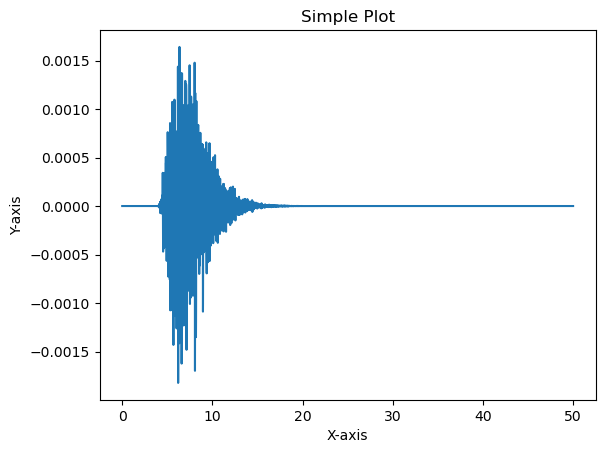

In [9]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start the matlab engine
eng = matlab.engine.start_matlab()
# Link to the dir of matlab function
eng.cd(r'C:\Users\v196m\Desktop\master_project\Masterarbeit\GroundMotion\GroundMotionGeneration', nargout=0)

# Parameter of GM setting
Time =  np.arange(0, 50.005, 0.005)

Time_info = np.array([3.93181817217733,	4.51602635361311,	6.51382766164269,	10.8203132545630])
FRF_info  = np.array([85.634147247517, 0.364521248606246, 0.213591303771144])
AriasIntensity = 0.0000508679639647511

# Generate ground motion
time,ampl = eng.fns_generateGM_Params([],Time,100,"Hu_S0", FRF_info, Time_info, AriasIntensity,1, nargout=2)

combined_array = np.column_stack((time, ampl))

# Create a plot
plt.plot(np.array(time), np.array(ampl))

# Add labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot')

# Show the plot
plt.show()

In [8]:
print(combined_array)


[[0.00000000e+00 0.00000000e+00]
 [5.00000000e-03 0.00000000e+00]
 [1.00000000e-02 0.00000000e+00]
 ...
 [4.99900000e+01 8.50248533e-18]
 [4.99950000e+01 5.91737672e-17]
 [5.00000000e+01 7.55237424e-17]]


### Testing ANSYS simulation from Python 

DOF:    28   Stress: 702.42 MPa
DOF:    48   Stress: 725.72 MPa
DOF:    57   Stress: 725.63 MPa
DOF:    66   Stress: 725.57 MPa
DOF:    78   Stress: 725.52 MPa
DOF:   124   Stress: 733.64 MPa
DOF:   144   Stress: 733.62 MPa
DOF:   215   Stress: 737.75 MPa
DOF:   250   Stress: 737.74 MPa
DOF:   354   Stress: 740.25 MPa
DOF:   490   Stress: 741.93 MPa
DOF:   656   Stress: 743.13 MPa
DOF:   873   Stress: 744.04 MPa
DOF:  1265   Stress: 745.32 MPa
DOF:  1632   Stress: 745.78 MPa
DOF:  2254   Stress: 746.50 MPa
DOF:  3230   Stress: 747.24 MPa
DOF:  4275   Stress: 747.60 MPa
DOF:  6141   Stress: 748.12 MPa
DOF:  8216   Stress: 748.40 MPa


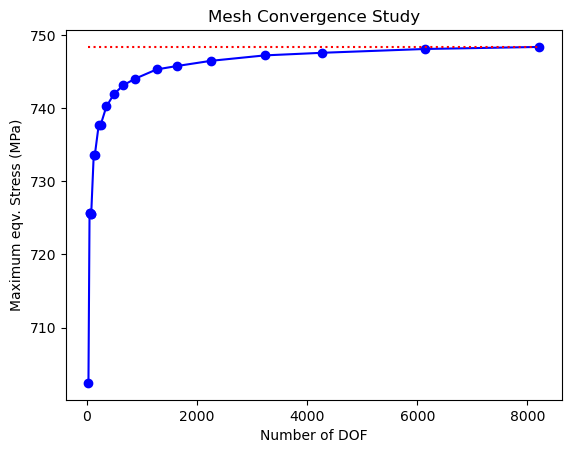

Widget(value='<iframe src="http://localhost:57044/index.html?ui=P_0x1e1677fafb0_6&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:57044/index.html?ui=P_0x1e167e5c490_7&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:57044/index.html?ui=P_0x1e167e5e4a0_8&reconnect=auto" class="pyvis…

In [6]:
"""
.. _2d_pressure_vessel_example:

2D Pressure Vessel
------------------

This example demonstrates how to create a basic pressure vessel and
apply a pressure to it.

Objective
~~~~~~~~~

In this example we will perform stress analysis of pipe due to internal
pressure. Due to the symmetry in geometry and loading, the strain along its axis
is negligible and therefore we model this system as 2D plane strain.

Procedure
~~~~~~~~~

* Launch MAPDL instance
* Setup the model as Python function using PyMAPDL
* Automate mesh convergence study
* Plot results of interest

Additional Packages Used
~~~~~~~~~~~~~~~~~~~~~~~~

* `Matplotlib <https://matplotlib.org>`_ is used for plotting purposes.
* `NumPy <https://numpy.org>`_ is used for using NumPy arrays.


Problem Figure
~~~~~~~~~~~~~~

.. image:: ../../../images/2d_pressure.png
   :width: 400
   :alt: Basic Pressure Vessel

"""

import matplotlib.pyplot as plt

###############################################################################
# Launch MAPDL
# ~~~~~~~~~~~~
import numpy as np

from ansys.mapdl.core import launch_mapdl

# start mapdl
mapdl = launch_mapdl()

###############################################################################
# Setup the pipe cross section using Python function
#
# We use a function here so we can rebuild the pipe using parameters rather than
# calling a script several times.


def pipe_plane_strain(e, nu, inn_radius, out_radius, press, aesize):
    """Create 2D cross section modeling a pipe."""

    # reset mapdl
    mapdl.clear()
    mapdl.prep7()

    # Define element attributes
    # Quad 4 node 182 with keyoption 3 = 2 (plain strain formulation)
    mapdl.et(1, "PLANE182", kop3=2)

    # Create geometry
    # create a quadrant of the pressure vessel
    # We perform plane strain analysis on one quadrant (0deg - 90deg) of the
    # pressure vessel
    mapdl.pcirc(inn_radius, out_radius, theta1=0, theta2=90)
    mapdl.components["PIPE_PROFILE"] = "AREA"

    # Define material properties
    mapdl.mp("EX", 1, e)  # Youngs modulus
    mapdl.mp("PRXY", 1, nu)  # Poissons ratio

    # Define mesh controls
    mapdl.aesize("ALL", aesize)
    mapdl.mshape(0, "2D")  # mesh the area with 2D Quad elements
    mapdl.mshkey(1)  # free mesh
    mapdl.cmsel("S", "PIPE_PROFILE")  # Select the area component to be meshed
    mapdl.amesh("ALL")

    # Create components for defining loads and constraints
    mapdl.nsel("S", "LOC", "X", 0)  # Select nodes on top left edge
    mapdl.components["X_FIXED"] = "NODES"  # Create nodal component

    mapdl.nsel("S", "LOC", "Y", 0)  # Select nodes on bottom right edge
    mapdl.components["Y_FIXED"] = "NODES"  # Create nodal component
    mapdl.allsel()

    mapdl.lsel("S", "RADIUS", vmin=rad1)  # Select the line along inner radius
    mapdl.components["PRESSURE_EDGE"] = "LINE"  # Create a line component
    mapdl.allsel()

    # Define solution controls
    mapdl.slashsolu()  # Enter solution
    mapdl.antype("STATIC", "NEW")  # Specify a new static analysis (Optional)

    mapdl.d("X_FIXED", "UX", 0)  # Fix the selected nodes in X direction
    mapdl.d("Y_FIXED", "UY", 0)  # Fix the selected nodes in Y direction

    # Change the active Cartesian Coordinate system to Cylindrical Coordinate system
    mapdl.csys(1)

    # Apply uniform pressure load to the selected edge
    mapdl.sfl("PRESSURE_EDGE", "PRES", press)

    # Solve the model
    mapdl.allsel()
    mapdl.solve()
    mapdl.finish()

    # Enter post-processor
    mapdl.post1()
    mapdl.set(1, 1)  # Select the first load step

    max_eqv_stress = np.max(mapdl.post_processing.nodal_eqv_stress())
    all_dof = mapdl.mesh.nnum_all
    num_dof = all_dof.size

    return num_dof, max_eqv_stress


###############################################################################
# Perform the mesh convergence study
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Define model input parameters
rad1 = 175  # Internal radius
rad2 = 200  # External radius
pressure = 100

e = 2e5  # Young's modulus
nu = 0.3  # Poisson's ratio

# Define mesh convergence parameters
num_dof = []
max_stress = []

# element size: use log space since mesh converges logarithmically
esizes = np.logspace(1.4, 0, 20)

# run the mesh convergence and output the results on the fly
for esize in esizes:
    dof, eqv_stress = pipe_plane_strain(e, nu, rad1, rad2, pressure, esize)
    num_dof.append(dof)
    max_stress.append(eqv_stress)
    print(f"DOF: {dof:5d}   Stress: {eqv_stress:.2f} MPa")


###############################################################################
# Plot mesh convergence results
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Draw a dotted line showing the convergence value

plt.plot(num_dof, max_stress, "b-o")
plt.plot([num_dof[0], num_dof[-1]], [max_stress[-1], max_stress[-1]], "r:")
plt.title("Mesh Convergence Study")
plt.xlabel("Number of DOF")
plt.ylabel("Maximum eqv. Stress (MPa)")
plt.show()

###############################################################################
# Resume results from last analysis from mesh convergence study

# Plot the final mesh used
mapdl.allsel("ALL")
mapdl.eplot(
    title="Element Plot",
    line_width=1,
    show_bounds=True,
    cpos="xy",
)

###############################################################################
# Plot nodal displacement
# ~~~~~~~~~~~~~~~~~~~~~~~
#
# Enter post-processing (/POST1) and select the first load step
mapdl.post1()
mapdl.set(1, 1)

mapdl.post_processing.plot_nodal_displacement(
    "NORM",
    cpos="xy",
    cmap="magma",
)

###############################################################################
# Plot nodal equivalent stress
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
mapdl.post_processing.plot_nodal_eqv_stress(cpos="xy", cmap="magma")

###############################################################################
# Stop mapdl
# ~~~~~~~~~~
#
mapdl.exit()
